## Weather Data : Initial Visualization

### Massachusetts

In [4]:
state="MA"

In [5]:
#sc.stop()

In [6]:
import pandas as pd
import numpy as np
import sklearn as sk
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
%%time
%run lib/startup-voc.py

172.17.0.2
sparkContext= <SparkContext master=local[2] appName=pyspark-shell>

    pandas as    pd 	version=2.0.3 	required version>=0.19.2

     numpy as    np 	version=1.24.4 	required version>=1.12.0

   sklearn as    sk 	version=1.3.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=3.5.0 	required version>=2.1.0

ipywidgets as ipywidgets 	version=8.1.1 	required version>=6.0.0

version of ipwidgets= 8.1.1


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


measurements is a Dataframe (and table) with 12720632 records
stations is a Dataframe (and table) with 119503 records
weather is a Dataframe (and table) which is a join of measurements and stations with 12720632 records
CPU times: user 202 ms, sys: 16.9 ms, total: 219 ms
Wall time: 5.71 s


In [8]:
sc

<SparkContext master=local[2] appName=pyspark-shell>

In [9]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

## Read Data

### show 3 rows of joined weather+stations table

In [10]:
### Total number of stations
stations.count()

119503

In [11]:
%%time
weather=measurements.join(stations,on='station')
weather.show(3)

+-----------+-----------+----+--------------------+--------+---------+---------+------------+-------------------+-----+-------+
|    Station|Measurement|Year|              Values|latitude|longitude|elevation|  dist2coast|               name|state|country|
+-----------+-----------+----+--------------------+--------+---------+---------+------------+-------------------+-----+-------+
|AG000060390|       TAVG|2022|[79 00 6C 00 66 0...| 36.7167|     3.25|     24.0|   8.0234375| ALGER-DAR EL BEIDA|     |Algeria|
|AGE00147716|       TAVG|2022|[85 00 83 00 7C 0...|    35.1|    -1.85|     83.0|0.5224609375|NEMOURS (GHAZAOUET)|     |Algeria|
|AGM00060360|       TMIN|2022|[5A 00 19 FC 4B 0...|  36.822|    7.809|      4.9|  3.16015625|             ANNABA|     |Algeria|
+-----------+-----------+----+--------------------+--------+---------+---------+------------+-------------------+-----+-------+
only showing top 3 rows

CPU times: user 2.15 ms, sys: 0 ns, total: 2.15 ms
Wall time: 875 ms


In [12]:
sqlContext.registerDataFrameAsTable(weather,'weather')

In [13]:
ms=['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS']
# ms=['TMAX', 'TMIN', 'TOBS']
cms='or\n'.join(['Measurement="%s" '%(m) for m in ms])

##  read all data for state
Query="""
SELECT *
FROM weather
WHERE state="%s" and 
(%s)
"""%(state,cms)
print(Query)


SELECT *
FROM weather
WHERE state="MA" and 
(Measurement="TMAX" or
Measurement="SNOW" or
Measurement="SNWD" or
Measurement="TMIN" or
Measurement="PRCP" or
Measurement="TOBS" )



In [14]:
%%time
weather_df=sqlContext.sql(Query)
print('number of rows in result=',weather_df.count())
weather_df.show(2)

number of rows in result= 49710
+-----------+-----------+----+--------------------+--------+---------+---------+-------------+--------------------+-----+-------------+
|    Station|Measurement|Year|              Values|latitude|longitude|elevation|   dist2coast|                name|state|      country|
+-----------+-----------+----+--------------------+--------+---------+---------+-------------+--------------------+-----+-------------+
|US1MABA0017|       PRCP|2022|[00 00 77 00 00 0...| 41.5828| -70.5803|     12.8| 0.9072265625|EAST FALMOUTH 1.2...|   MA|United States|
|US1MABA0018|       SNOW|2022|[00 00 00 00 19 F...| 41.5818| -70.5257|      9.8|0.94091796875|     WAQUOIT 0.6 SSW|   MA|United States|
+-----------+-----------+----+--------------------+--------+---------+---------+-------------+--------------------+-----+-------------+
only showing top 2 rows

CPU times: user 2.8 ms, sys: 0 ns, total: 2.8 ms
Wall time: 1.5 s


### read or compute statistics information for state.

In [15]:
%%time
import os.path
from lib.computeStatistics import computeStatistics
from pickle import dump,load

pkl_filename=parquet_root+'weather-statistics/'+state+'-'+','.join(ms)+'.pkl'
print(pkl_filename)
!ls $pkl_filename

../Data/Weather/weather/datasets/weather-statistics/MA-TMAX,SNOW,SNWD,TMIN,PRCP,TOBS.pkl
../Data/Weather/weather/datasets/weather-statistics/MA-TMAX,SNOW,SNWD,TMIN,PRCP,TOBS.pkl
CPU times: user 2.44 ms, sys: 5.91 ms, total: 8.36 ms
Wall time: 217 ms


In [16]:
%%time
if os.path.isfile(pkl_filename):   
    print('precomputed statistics file exists')
    with open(pkl_filename,'br') as pkl_file:
        STAT=load(pkl_file)
else:
    print('computing statistics')
    STAT=computeStatistics(sqlContext,weather_df,measurements=ms)
    with open(pkl_filename,'bw') as pkl_file:
        dump(STAT,pkl_file)

STAT.keys()

precomputed statistics file exists
CPU times: user 0 ns, sys: 27.7 ms, total: 27.7 ms
Wall time: 38 ms


dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])

In [17]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
        NE	         count of defined values per day	(366,)
SortedVals	                        Sample of values	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(366,)
      Mean	                                    E/NE	(366,)
         O	                   Sum of outer products	(366, 366)
        NO	               counts for outer products	(366, 366)
       Cov	                

### print statistics for TOBS

In [18]:
S=STAT['TOBS']
for key in ['mean', 'std', 'low100', 'high100']:
    element=S[key]
    print(key,'=',end='')
    if type(element)==numpy.float64 or type(element)==numpy.float16:
        print('%6.2f'%element)
    elif type(element)==numpy.ndarray:
        print (element)
    else:
        print('unidentified type=',type(element))

mean =  8.31
std = 10.31
low100 =-11.70
high100 = 30.59


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


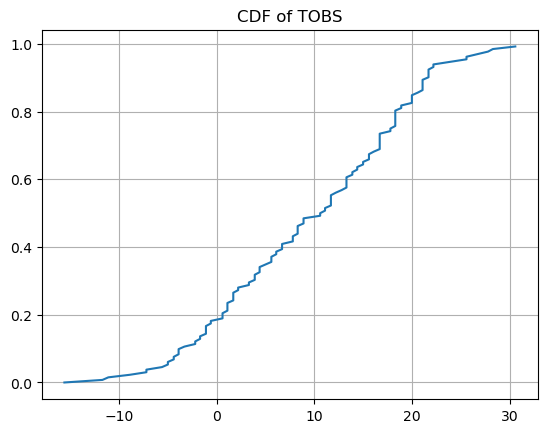

In [19]:
%pylab inline
measurement='TOBS'
Sobs=STAT[measurement]['SortedVals']

#figure(figsize=[15,10])
n_obs=Sobs.shape[0]
p=arange(0,1,1/n_obs)
plot(Sobs,p)
title('CDF of '+measurement)
grid()

### distribution of undefined elements in yearly measurements.

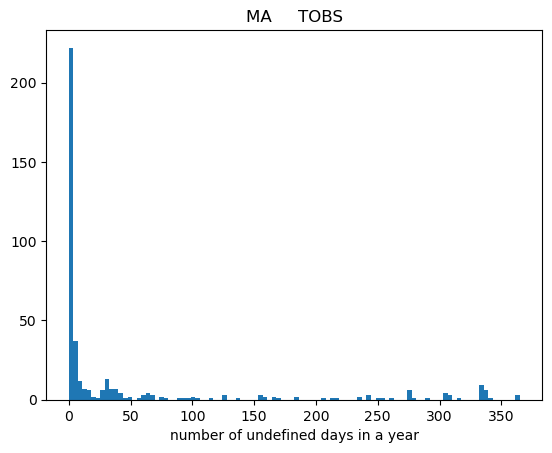

In [20]:
hist(S['UnDef'],bins=100);
xlabel('number of undefined days in a year');
title(state+'     '+measurement);

In [21]:
%%time
## Find the number of measurements of each of the common 6 types in MA

Query="""
select Measurement,count(Measurement) as count
from weather
WHERE state='%s'
GROUP BY Measurement
ORDER BY count DESC
"""%state
sqlContext.sql(Query).show(15)

+-----------+-----+
|Measurement|count|
+-----------+-----+
|       PRCP|12304|
|       SNOW|11379|
|       SNWD| 8750|
|       TMIN| 6524|
|       TMAX| 6502|
|       WT03| 4830|
|       TOBS| 4251|
|       WT01| 3707|
|       WT04| 3368|
|       MDPR| 2825|
|       DAPR| 2789|
|       WT06| 1962|
|       WT16| 1900|
|       WT05| 1775|
|       WT18| 1722|
+-----------+-----+
only showing top 15 rows

CPU times: user 57.4 ms, sys: 0 ns, total: 57.4 ms
Wall time: 1.35 s


### Find out the definition of measurement types

In [22]:
!grep SNWD $parquet_root/noaa/readme.txt

	   SNWD = Snow depth (mm)


In [23]:
!grep MDPR $parquet_root/noaa/readme.txt

	          total (MDPR)
	          multiday precipitation total (MDPR)
	   MDPR = Multiday precipitation total (tenths of mm; use with DAPR and 


## Find the number of measurements (years) for each station in state

In [24]:
Query="""
select Station,count(Station) as count
from weather
WHERE state='%s' and Measurement='TOBS'
GROUP BY Station
ORDER BY count DESC
"""%state
#print(Query)
tmp=sqlContext.sql(Query)
print(tmp.count())
tmp.show(3)

160
+-----------+-----+
|    Station|count|
+-----------+-----+
|USC00194105|  122|
|USC00193505|  120|
|USC00196486|  107|
+-----------+-----+
only showing top 3 rows



### show details of state

In [25]:
station="USC00072730"
Query="""
select * from stations
WHERE Station="%s"
"""%station
sqlContext.sql(Query).show()

+-----------+--------+---------+---------+----------+-----+-----+-------------+
|    station|latitude|longitude|elevation|dist2coast| name|state|      country|
+-----------+--------+---------+---------+----------+-----+-----+-------------+
|USC00072730| 39.1467| -75.5056|      9.1|    8.4375|DOVER|   DE|United States|
+-----------+--------+---------+---------+----------+-----+-----+-------------+



### find how many measurements of each type for a particlar station

In [26]:
Query="""
SELECT Measurement,count(Measurement) as count 
FROM weather
WHERE Station='%s' 
GROUP BY Measurement
ORDER BY count DESC
"""%station
sqlContext.sql(Query).show(8)

+-----------+-----+
|Measurement|count|
+-----------+-----+
|       TMIN|  120|
|       TMAX|  120|
|       SNOW|  120|
|       PRCP|  120|
|       TOBS|  115|
|       SNWD|  104|
|       WT03|   78|
|       WT01|   58|
+-----------+-----+
only showing top 8 rows



### find year with all measurements

In [27]:
%%time
#find year with all measurements
Query="""
SELECT Year,count(Year) as count 
FROM weather
WHERE Station='%s' 
GROUP BY Year
ORDER BY count DESC
"""%station
pdf=sqlContext.sql(Query).toPandas()

pdf.head()

CPU times: user 27.1 ms, sys: 13.2 ms, total: 40.4 ms
Wall time: 1.1 s


,Year,count
0,1934,16
1,2015,13
2,2011,13
3,2016,13
4,1961,13


In [28]:
from collections import Counter
Counter(list(pdf['count']))

Counter({8: 23,
         9: 19,
         10: 15,
         6: 15,
         12: 12,
         11: 12,
         5: 9,
         7: 6,
         13: 4,
         4: 4,
         16: 1})

### get all measurements for year=1960, measurement="TOBS"  and state="DE"

In [29]:
year=1990
Query="""
SELECT *
FROM weather
WHERE Year='%s' 
and Measurement='TOBS'
and State='%s'
"""%(year,state)
df=sqlContext.sql(Query)
print(df.count())
df.show(3)

39
+-----------+-----------+----+--------------------+--------+---------+---------+----------+---------------+-----+-------------+
|    Station|Measurement|Year|              Values|latitude|longitude|elevation|dist2coast|           name|state|      country|
+-----------+-----------+----+--------------------+--------+---------+---------+----------+---------------+-----+-------------+
|USC00193890|       TOBS|1990|[38 00 EF FF 16 0...| 42.3031| -71.1242|     29.0|7.80859375|  JAMAICA PLAIN|   MA|United States|
|USC00193985|       TOBS|1990|[16 00 DF FF F5 F...| 42.2833| -72.8667|    192.0|     111.0|KNIGHTVILLE DAM|   MA|United States|
|USC00194313|       TOBS|1990|[D9 FF B2 FF C3 F...| 42.6408| -71.3636|     33.5|  41.34375|         LOWELL|   MA|United States|
+-----------+-----------+----+--------------------+--------+---------+---------+----------+---------------+-----+-------------+
only showing top 3 rows



In [30]:
%%time

## Collect measurements for selected rows
ListOfRows=df.rdd.map(lambda x: (x.Station,unpackAndScale(x))).collect()
_labels = [x[0] for x in ListOfRows]
M=stack([x[1] for x in ListOfRows])
M.shape
        

CPU times: user 3.72 ms, sys: 6.51 ms, total: 10.2 ms
Wall time: 1.56 s


(39, 366)

### Plot all 35 the TOBS measurements

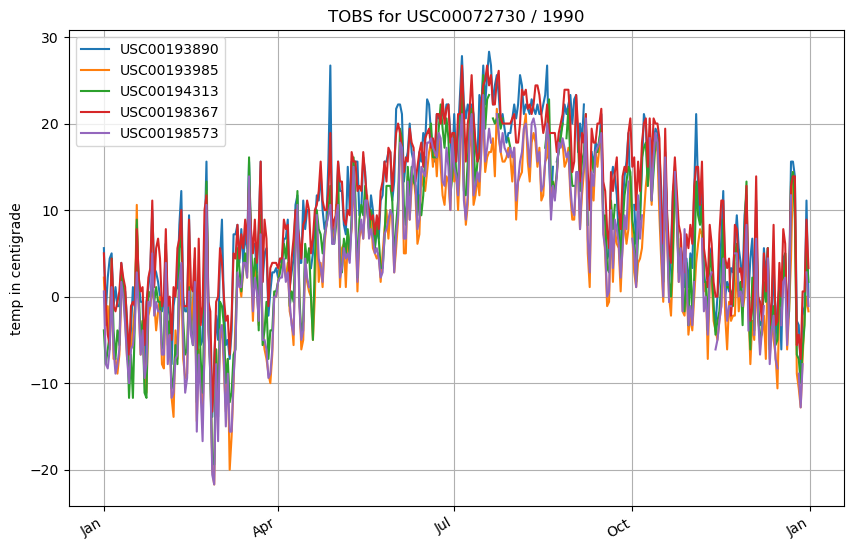

In [31]:
from lib.YearPlotter import YearPlotter
k=5
_title='TOBS for %s / %d'%(station,year)
fig, ax = plt.subplots(figsize=_figsize);
YP=YearPlotter()
YP.plot(M[:k,:366].T,fig,ax,title=_title,labels=_labels)# ,labels=labels);
ylabel('temp in centigrade');

### Plot all 35 TOBS measurements

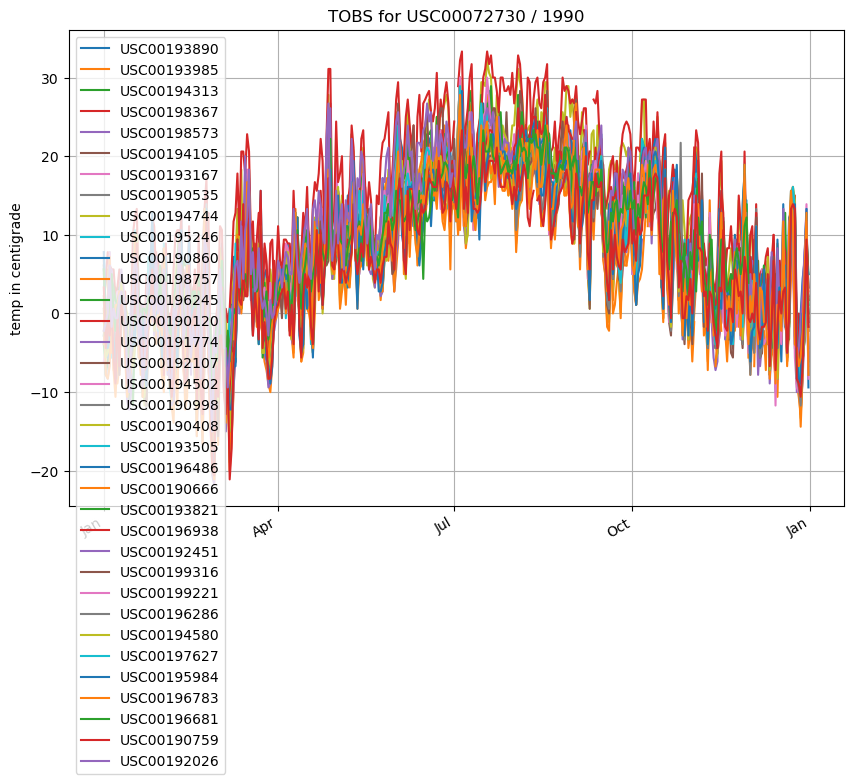

In [32]:
#looking at all of the year creates a mess
from lib.YearPlotter import YearPlotter
k=35
fig, ax = plt.subplots(figsize=_figsize);
YP=YearPlotter()
YP.plot(M[:k,:366].T,fig,ax,title=_title,labels=_labels)# ,labels=labels);
ylabel('temp in centigrade');

### Zooming into a small number of days the correlations between stations are clear.

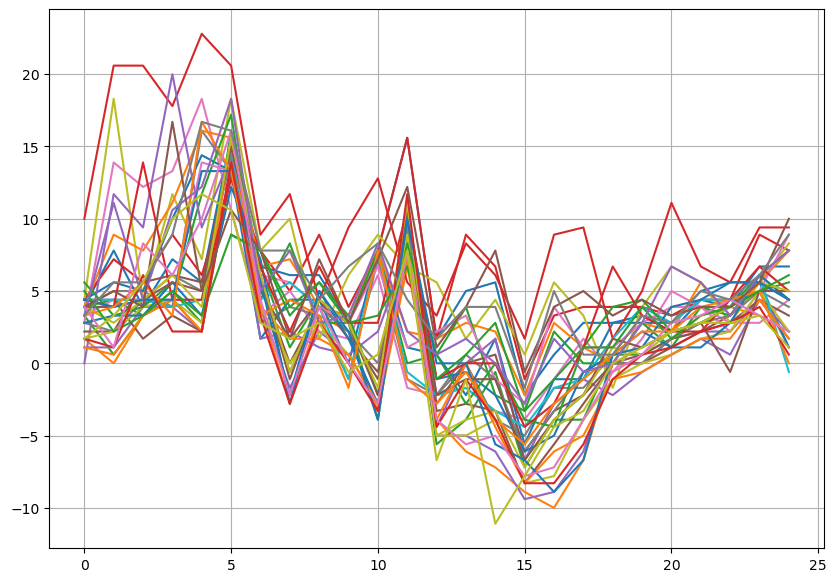

In [33]:
## Looking at a small range of days  across all stations in state reveals 
## Interesting clustering
figure(figsize=_figsize)
plot(M[:,70:95].transpose());
grid()

In [34]:
# get all measurements for a particular year and a particular station
Query="""
SELECT *
FROM weather
WHERE Station='%s' 
and Year=%d
"""%(station,year )
print(Query)
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
print('pandas_df.shape=',pandas_df.shape)
print('pandas_df.columns=',pandas_df.columns)


SELECT *
FROM weather
WHERE Station='USC00072730' 
and Year=1990

pandas_df.shape= (9, 10)
pandas_df.columns= Index(['Station', 'Year', 'Values', 'latitude', 'longitude', 'elevation',
       'dist2coast', 'name', 'state', 'country'],
      dtype='object')


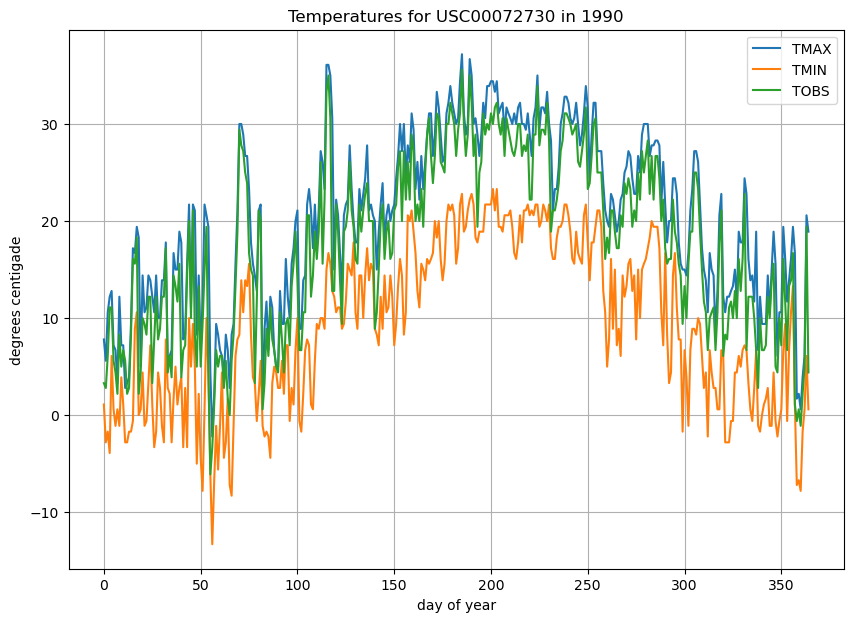

In [35]:
_tmax=unpackArray(pandas_df.loc['TMAX','Values'],np.int16)/10.
_tmin=unpackArray(pandas_df.loc['TMIN','Values'],np.int16)/10.
_tobs=unpackArray(pandas_df.loc['TOBS','Values'],np.int16)/10.
figure(figsize=_figsize)
plot(_tmax,label='TMAX');
plot(_tmin,label='TMIN');
plot(_tobs,label='TOBS');

xlabel('day of year')
ylabel('degrees centigade')
title('Temperatures for %s in %d'%(station,year))
legend()
grid()

### Script for plotting yearly plots

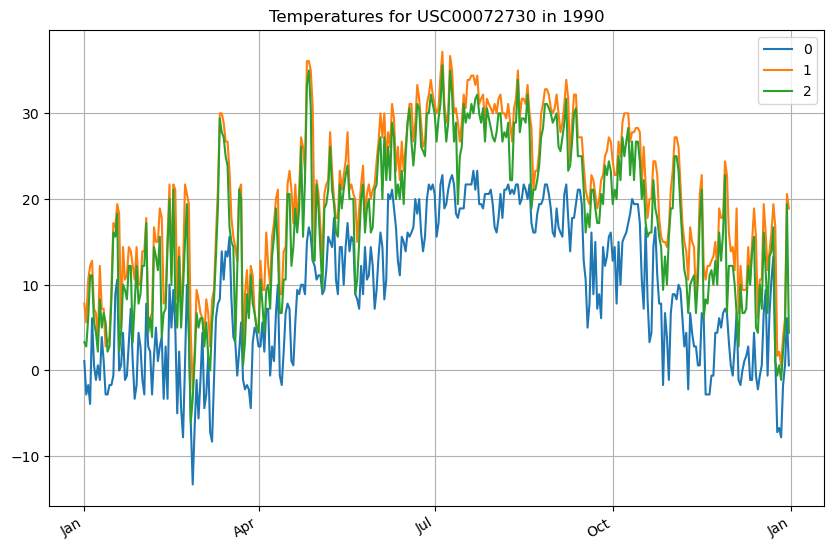

In [36]:
from lib.YearPlotter import YearPlotter
T=np.stack([_tmin,_tmax,_tobs])

fig, ax = plt.subplots(figsize=_figsize);
YP=YearPlotter()
YP.plot(T.transpose(),fig,ax,title='Temperatures for %s in %d'%(station,year));
plt.savefig('percipitation.png')
#title('A sample of graphs');

## Statistics across the state

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [37]:
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

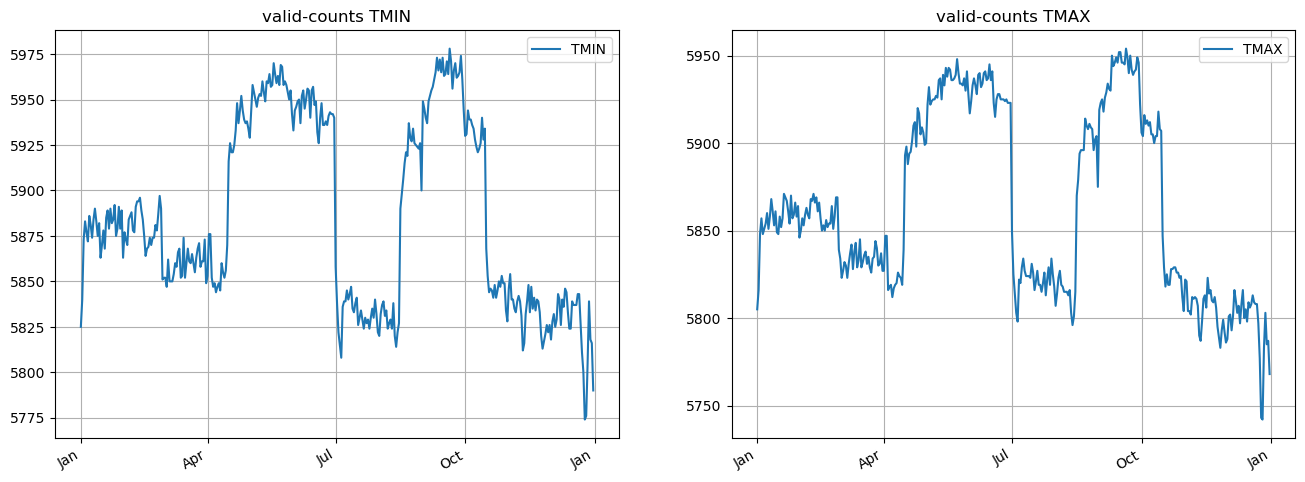

In [38]:
plot_pair(['TMIN','TMAX'],plot_valid)

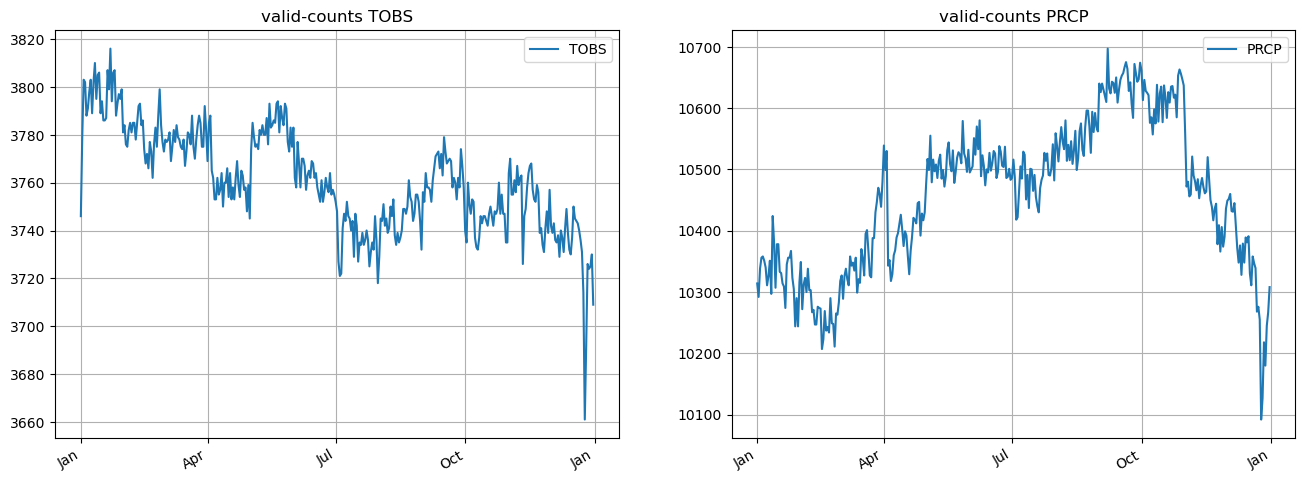

In [39]:
plot_pair(['TOBS','PRCP'],plot_valid)

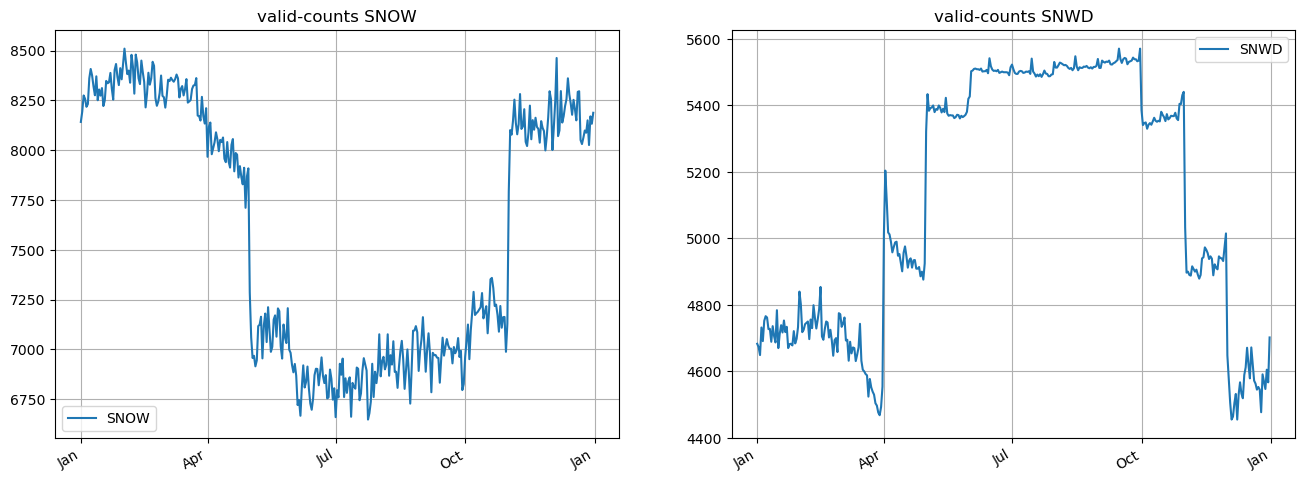

In [40]:
# Note that for "SNOW" there are more missing measurements in the summer
# While for SNWD there are less missing in the summer
# Question: do these anomalies involve the same stations?
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [41]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in percipitation):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



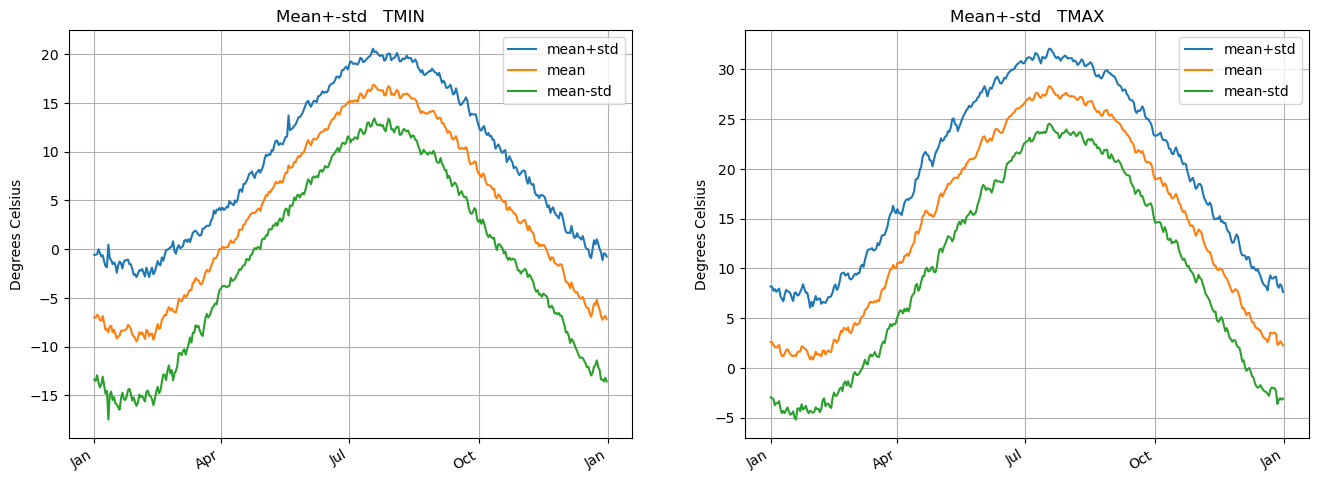

In [42]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

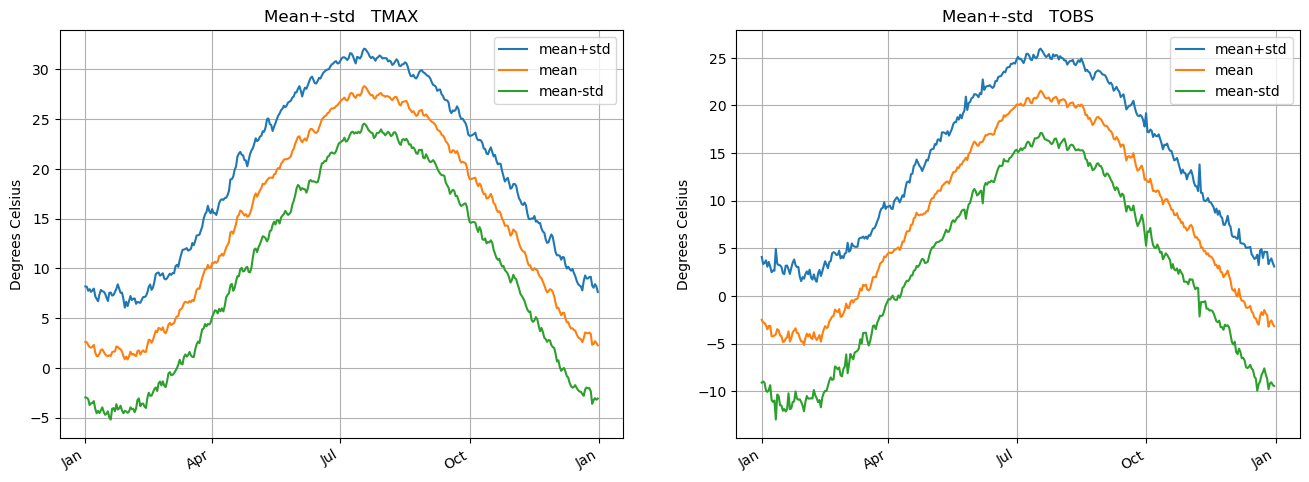

In [43]:
plot_pair(['TMAX','TOBS'],plot_mean_std)

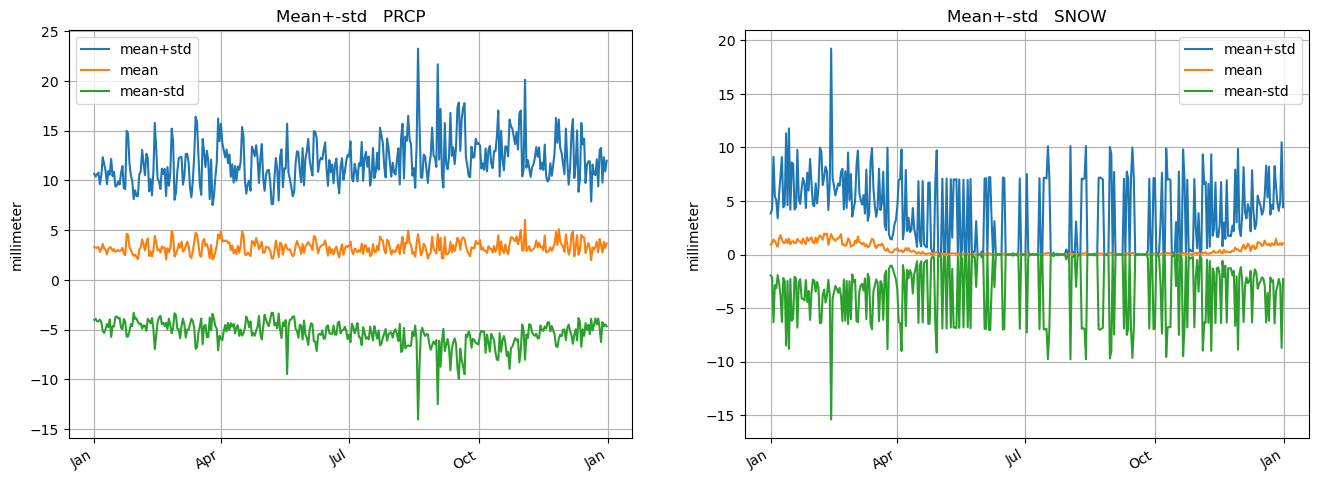

In [44]:
plot_pair(['PRCP','SNOW'],plot_mean_std)

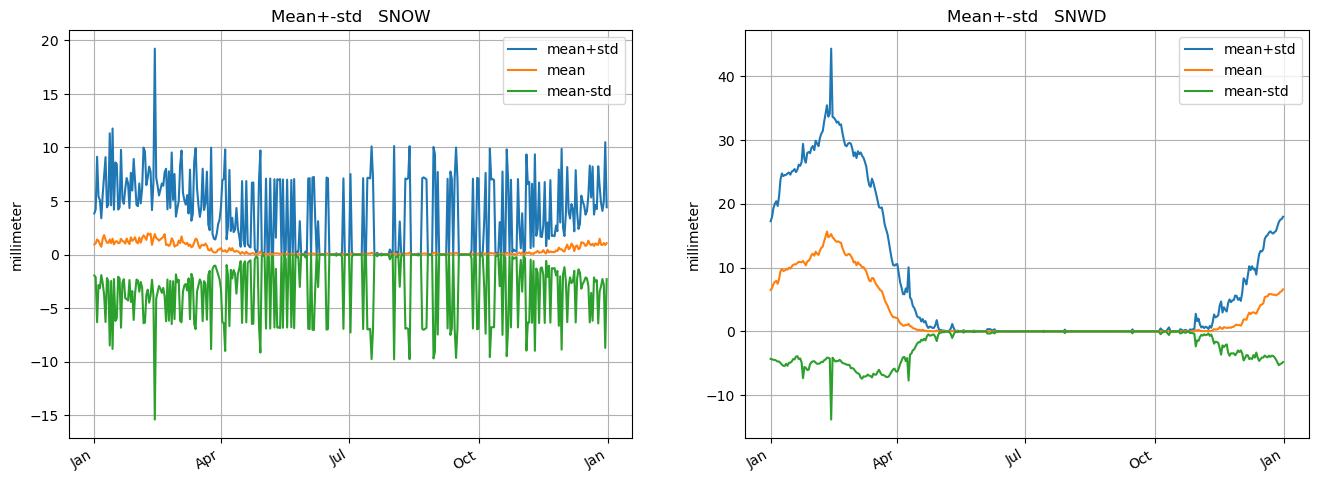

In [45]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

## Conclusion

* We loaded the weather data from Parquet files.
* We explored statistics for the data.
* We explored where there are a lot of empty cells - limits the accuracy of the statistics.
* We visualized different measurements as a function of the day of the year.
* **next** Using PCA for more refined analysis.